## Manually Label Project Metaphors

Randomly select projects and extract potential metaphors. Manually label whether the presented text fragment contains a metaphorical cancer-related phrase. Focus given to the underlined keyword token.

In [1]:
import os.path as op

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import pandas as pd

import re

In [2]:
DATA_PROCESSED = '../data/processed'

UNDERLINE = '\033[4m'
END = '\033[0m'

In [3]:
df = pd.read_csv(op.join(DATA_PROCESSED, 'cancer_projects.csv'))

In [4]:
len(df)

455

In [5]:
try:
    labeled = pd.read_csv(op.join(DATA_PROCESSED, 'labeled_projects.csv'))
    print('Loaded existing labels')
except (pd.errors.EmptyDataError, FileNotFoundError):
    labeled = pd.DataFrame([], columns=['project_id', 'fragment', 'char_location', 'type', 'keyword'])
    labeled.to_csv(op.join(DATA_PROCESSED, 'labeled_projects.csv'))
    print('Created new label file')

Loaded existing labels


In [6]:
len(labeled)

645

In [7]:
# these are ordered lists - since we search in order the lemma comes last (so not to catch non-lemma'd words)

BATTLE_WORDS = ['fights', 'fighting', 'fight', 'fought', 'battles', 'battled', 'battling', 'battle', 'war', 'beating', 'beats', 'beaten', 'beat', 'enemy', 'brutal']

JOURNEY_WORDS = ['path', 'journey', 'destination']

window = 80

# Manually Label Metaphors

In [ ]:
results = []

narrowed = df[~df['id'].isin(labeled['project_id'])].copy()
print(f'Maximum N: {len(narrowed)}')

c = input('N: ')

try:
    c = int(c)
except Exception:
    print('Format error')
        
proj_sample = narrowed.sample(c)

for project in proj_sample.itertuples():
    
    print()
    print(f'PROJECT {project.name}')
    
    metaphor = False
    
    for battle_word in BATTLE_WORDS:
        
        if not isinstance(project.text, str):
            break
        
        exp = r'\W(' + battle_word + ')\W'

        for kw_match in re.finditer(exp, project.text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(project.text), kw_match.end() + window)

            print(project.text[start:kw_match.start()] + 
                  UNDERLINE + 
                  project.text[kw_match.start():kw_match.end()-1] + 
                  END + 
                  project.text[kw_match.end()-1:end])
            
            res = input('Is this a cancer battle metaphor? ')
            
            if res.lower() == 'y':
                results.append([project.id, project.text[start:end], kw_match.start(), 'battle', battle_word])
                metaphor = True
                                
    for journey_word in JOURNEY_WORDS:
        
        if not isinstance(project.text, str):
            break
        
        exp = r'\W(' + journey_word + ')\W'

        for kw_match in re.finditer(exp, project.text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(project.text), kw_match.end() + window)

            print(project.text[start:kw_match.start()] + 
                  UNDERLINE + 
                  project.text[kw_match.start():kw_match.end()-1] + 
                  END + 
                  project.text[kw_match.end()-1:end])
            
            res = input('Is this a cancer journey metaphor? ')
            
            if res.lower() == 'y':
                results.append([project.id, project.text[start:end], kw_match.start(), 'journey', journey_word])
                metaphor = True
                
    if not metaphor:
        results.append([project.id, '', np.nan, 'none', ''])
        print('No metaphors found')
                            
results = pd.DataFrame(results, columns=['project_id', 'fragment', 'char_location', 'type', 'keyword'])

labeled = pd.concat([labeled, results], axis=0, ignore_index=True).drop_duplicates(subset=['project_id', 'char_location'])

labeled.to_csv(op.join(DATA_PROCESSED, 'labeled_projects.csv'), index=False)

print()
print(f'Saved {len(results)} for a total of {len(labeled)}!')

del results, proj_sample, narrowed

In [ ]:
print(f'Total metaphor examples: {len(labeled.loc[labeled["type"] != "none", :])}')

plt.subplots(1, 2, figsize=(16,4))

plt.subplot(1,2,1)
vc = labeled.loc[labeled['type'] != 'none', 'keyword'].value_counts();
sns.barplot(vc.index, vc.values)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1,2,2)
vc = labeled['type'].value_counts()
g = sns.barplot(vc.index, vc.values, palette='husl')
plt.grid(axis='y', alpha=0.3)

s = sum(vc.values)
for p in g.patches:
    h = p.get_height()
    plt.text(p.get_x() + 0.3, h - 20, f'{h/s*100:.2f}%')

### TODO

o how productive a metaphor is (**creatively** using metaphor). 

o is the campaign about raising money for research, product, book, diets, etc. journey as raising money

x add enemy as keyword

o add "fighter" as keyword

o cancer fighting the patient, not the other way around - bring in POS to figure out if cancer is a subject or object, "cancer can’t beat us", "battle scars"

o situational model, looking at prosidy in speech

o measure of distinct words in a campaign

o characterizing metaphors with types of projects

**Instances of Keyword used not in Metaphor**

My wife beat me to the shower

don’t beat around the bush

an underground fight club

Gulf War-influenced The New World

# Relabel Missed

In [ ]:
false_positives = []

In [ ]:
for project in df.sample(frac=1).itertuples():
    
    print()
    print(f'PROJECT {project.name}')
        
    for battle_word in BATTLE_WORDS:
        
        if not isinstance(project.text, str):
            break
        
        exp = r'\W(' + battle_word + ')\W'

        for kw_match in re.finditer(exp, project.text.lower()):
            
            if (np.abs(float(kw_match.start()) - labeled.loc[labeled['project_id'] == project.id, 'char_location'].values) < 4).any():
                continue
                
            if pd.isnull(labeled.loc[labeled['project_id'] == project.id, 'char_location']).any():
                continue
    
            start, end = max(0, kw_match.start() - window), min(len(project.text), kw_match.end() + window)
            print(project.text[start:kw_match.start()] + 
                  UNDERLINE + 
                  project.text[kw_match.start():kw_match.end()-1] + 
                  END + 
                  project.text[kw_match.end()-1:end])

            res = input('Is this a cancer battle metaphor? ')

            if res.lower() == 'y':
                labeled = labeled.append({'project_id': project.id, 
                                'fragment': project.text[start:end], 
                                'char_location': kw_match.start(), 
                                'type': 'battle', 
                                'keyword': battle_word}, ignore_index=True)
            else:
                false_positives.append({'project_id': project.id, 
                                'fragment': project.text[start:end], 
                                'char_location': kw_match.start(), 
                                'type': 'battle', 
                                'keyword': battle_word})
                                
    for journey_word in JOURNEY_WORDS:
        
        if not isinstance(project.text, str):
            break
        
        exp = r'\W(' + journey_word + ')\W'

        for kw_match in re.finditer(exp, project.text.lower()):
            
            if (np.abs(float(kw_match.start()) - labeled.loc[labeled['project_id'] == project.id, 'char_location'].values) < 4).any():
                continue
                
            if pd.isnull(labeled.loc[labeled['project_id'] == project.id, 'char_location']).any():
                continue
                
            start, end = max(0, kw_match.start() - window), min(len(project.text), kw_match.end() + window)
            print(project.text[start:kw_match.start()] + 
                  UNDERLINE + 
                  project.text[kw_match.start():kw_match.end()-1] + 
                  END + 
                  project.text[kw_match.end()-1:end])

            res = input('Is this a cancer journey metaphor? ')

            if res.lower() == 'y':
                labeled = labeled.append({'project_id': project.id, 
                                'fragment': project.text[start:end], 
                                'char_location': kw_match.start(), 
                                'type': 'journey', 
                                'keyword': journey_word}, ignore_index=True)
            else:
                false_positives.append({'project_id': project.id, 
                                'fragment': project.text[start:end], 
                                'char_location': kw_match.start(), 
                                'type': 'journey', 
                                'keyword': journey_word})

In [ ]:
len(labeled), len(false_positives)

In [ ]:
labeled.to_csv(op.join(DATA_PROCESSED, 'labeled_projects.csv'), index=False)

In [ ]:
pd.DataFrame(false_positives).to_csv(op.join(DATA_PROCESSED, 'false_positive_metaphors.csv'), index=False)

# Auto-Detection

In [8]:
a = pd.read_csv(op.join(DATA_PROCESSED, 'labeled_projects.csv')).dropna()
b = pd.read_csv(op.join(DATA_PROCESSED, 'false_positive_metaphors.csv'))
a['metaphorical'] = True
b['metaphorical'] = False

instances = pd.concat([a, b], ignore_index=True, sort=False)

In [9]:
def find_metaphors(text):
    if not isinstance(text, float):
            
        if 'cancer' in text.lower():
            for kw_match in re.finditer(r'\W(fight)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': 'fight'}
                
            for kw_match in re.finditer(r'\W(fights)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': 'fights'}
                
            for kw_match in re.finditer(r'\W(fighting)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': 'fighting'}

            for kw_match in re.finditer(r'\W(fought)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': 'fought'}
                
            for kw_match in re.finditer(r'\W(battle)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                        'char_location': kw_match.start(), 
                        'type': 'battle', 
                        'keyword': 'battle'}
                
            for kw_match in re.finditer(r'\W(battles)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': 'battles'} 
                        
            for kw_match in re.finditer(r'\W(battling)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': 'battling'}

            for kw_match in re.finditer(r'\W(battled)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': 'battled'}
                
            for kw_match in re.finditer(r'\W(beat)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': 'beat'}
            
            for kw_match in re.finditer(r'\W(beats)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': 'beats'}
                
            for kw_match in re.finditer(r'\W(beaten)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': 'beaten'}
                
            for kw_match in re.finditer(r'\W(beating)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': 'beating'}
                
            if 'character' not in text.lower() and 'hero' not in text.lower():
                for kw_match in re.finditer(r'\W(enemy)\W', text.lower()):
                    start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                    yield {'fragment': text[start:end],
                           'char_location': kw_match.start(), 
                           'type': 'battle', 
                           'keyword': 'enemy'}
                
            for kw_match in re.finditer(r'\W(brutal)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': 'brutal'}
                
            for kw_match in re.finditer(r'\W(journey)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                next_ = text[kw_match.start():kw_match.end()+20].split()
                if len(next_) > 1 and next_[1] not in ['from', 'will']:
                    yield {'fragment': text[start:end],
                           'char_location': kw_match.start(), 
                           'type': 'journey', 
                           'keyword': 'journey'}
                else:
                    print(next_)
        
        for kw_match in re.finditer(r'\W(war (with|against) cancer)\W', text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() - 8 + window)
            yield {'fragment': text[start:end],
                   'char_location': kw_match.start(), 
                   'type': 'battle', 
                   'keyword': 'war'}

In [12]:
instances.loc[(instances['keyword'] == 'journey') & (instances['metaphorical'] == False), 'fragment'].values

array([" for she has had her fair share of ups and down. Although she hasn't had an easy journey in life, it has never phased her as a person. Diogo Hausen has been working as a",
       'ing responsibility, Rupert must embark on a hilarious, insightful and meaningful journey through the words and actions of these female patients.\xa0 There is nothing funny ',
       "\xa0 In short, DON'T BLINK is an eight-episode television show following the journey of four friends as they travel around Wisconsin chasing 14 of their most excitin",
       ' items we are going after,” Gregory proudly announced. Accompanying them on this journey will be a camera crew filming an 8-part, Wisconsin travel/adventure series calle',
       '"Beauty From Ash" is an album of songs about my journey as I\'ve walked through the most difficult time in my life - my son\'s battle with',
       "eat with a purpose, it's time to Fight Cancer With a Fork! \xa0Please join me on my journey and thank you for being apart of

In [10]:
counts = {t: {k: 0 for k in instances['keyword'].unique()} for t in ['fn', 'tn', 'tp', 'fp']}
totals = dict(instances['keyword'].value_counts())

for ix, project_instances in instances.sample(frac=1).groupby('project_id'):
    result = np.array(['fn']*len(project_instances)) # we currently haven't found any metaphors
    for metaphor in find_metaphors(df.loc[df['id'] == ix, 'text'].values[0]):
        mask = np.abs(metaphor['char_location'] - project_instances['char_location']) < 4
        
        if sum(mask) == 1:
            # did the mask find at least one instance of this metaphor we've recorded
            metaphorical = project_instances[mask]['metaphorical'].values[0]
            if metaphorical:
                result[mask] = 'tp' # we found a metaphor instance and it actually is a metaphor
            else:
                result[mask] = 'fp' # we found a metaphor instance but it's not a metaphor
                    
    for i, r in enumerate(result):
        if r == 'fn' and project_instances.iloc[i]['metaphorical'] == False:
            result[i] = 'tn' # we didn't catch these non-metaphor instances: good
            
        # else: we didn't catch something we should have
                            
    for i, r in enumerate(result):
        counts[r][project_instances.iloc[i]['keyword']] += 1

['journey', 'will', 'not', 'be', 'lost.', 'Th']
['journey', 'will', 'start', 'June', '1st,']
['journey', 'from', 'being', 'diagnosed']
['journey', 'from', 'their', 'unlikely']
['journey', 'will', 'not', 'be', 'lost.', 'Th']
['journey', 'from', 'cancer', 'to', 'welln']
['journey.']
['journey', 'will', 'be', 'a', 'camera', 'cre']
['journey', 'from', 'Calgary,', 'Albert']


In [17]:
# instances['prediction'] = np.nan
instances.sample(5)

,project_id,fragment,char_location,type,keyword,metaphorical,prediction
302,1105507467,reward to this whole breast cancer battle. Th...,5056.0,journey,journey,True,True
137,8143920,"one reading this I want to say , If you have a...",1446.0,battle,fighting,True,True
130,1857493693,"fe's struggles as we fight to overcome, rise u...",1187.0,battle,battle,True,True
43,1619907121,o much more — it is about educating the commun...,2936.0,battle,battle,True,True
384,410542533,during cancer treatment. Let’s help steal bac...,277.0,battle,battles,False,True


In [14]:
from sklearn.metrics import precision_score, recall_score

In [15]:
instances['prediction'] = False

for ix, instance in instances.iterrows():
    for metaphor in find_metaphors(df.loc[df['id'] == instance['project_id'], 'text'].values[0]):
        if np.abs(metaphor['char_location'] - instance['char_location']) < 4:
            instances.iloc[ix, 6] = True
            break

['journey.']
['journey', 'will', 'not', 'be', 'lost.', 'Th']
['journey', 'from', 'being', 'diagnosed']
['journey', 'from', 'being', 'diagnosed']
['journey', 'will', 'not', 'be', 'lost.', 'Th']
['journey', 'will', 'not', 'be', 'lost.', 'Th']
['journey', 'from', 'Calgary,', 'Albert']
['journey', 'from', 'cancer', 'to', 'welln']
['journey', 'from', 'their', 'unlikely']
['journey', 'will', 'be', 'a', 'camera', 'cre']
['journey', 'from', 'their', 'unlikely']
['journey', 'will', 'start', 'June', '1st,']
['journey', 'will', 'start', 'June', '1st,']
['journey', 'will', 'start', 'June', '1st,']
['journey', 'will', 'start', 'June', '1st,']
['journey', 'will', 'start', 'June', '1st,']
['journey', 'will', 'start', 'June', '1st,']
['journey', 'will', 'start', 'June', '1st,']
['journey', 'from', 'Calgary,', 'Albert']
['journey', 'from', 'Calgary,', 'Albert']


In [18]:
scores = []

vc = instances['keyword'].value_counts()

for ix, kw in instances.groupby('keyword'):
    scores.append({'keyword': ix, 'score': precision_score(kw['metaphorical'], kw['prediction']), 
                   'metric': 'precision', 'c': vc[vc.index == ix].values[0]})
    scores.append({'keyword': ix, 'score': recall_score(kw['metaphorical'], kw['prediction']), 
                   'metric': 'recall', 'c': vc[vc.index == ix].values[0]})
    
scores = pd.DataFrame(scores).sort_values(by='c', ascending=False)

/Users/alex/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
sum(pd.read_csv('../../GoFundMe/data-raw/cancer_urls.csv').duplicated()

0

/Users/alex/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


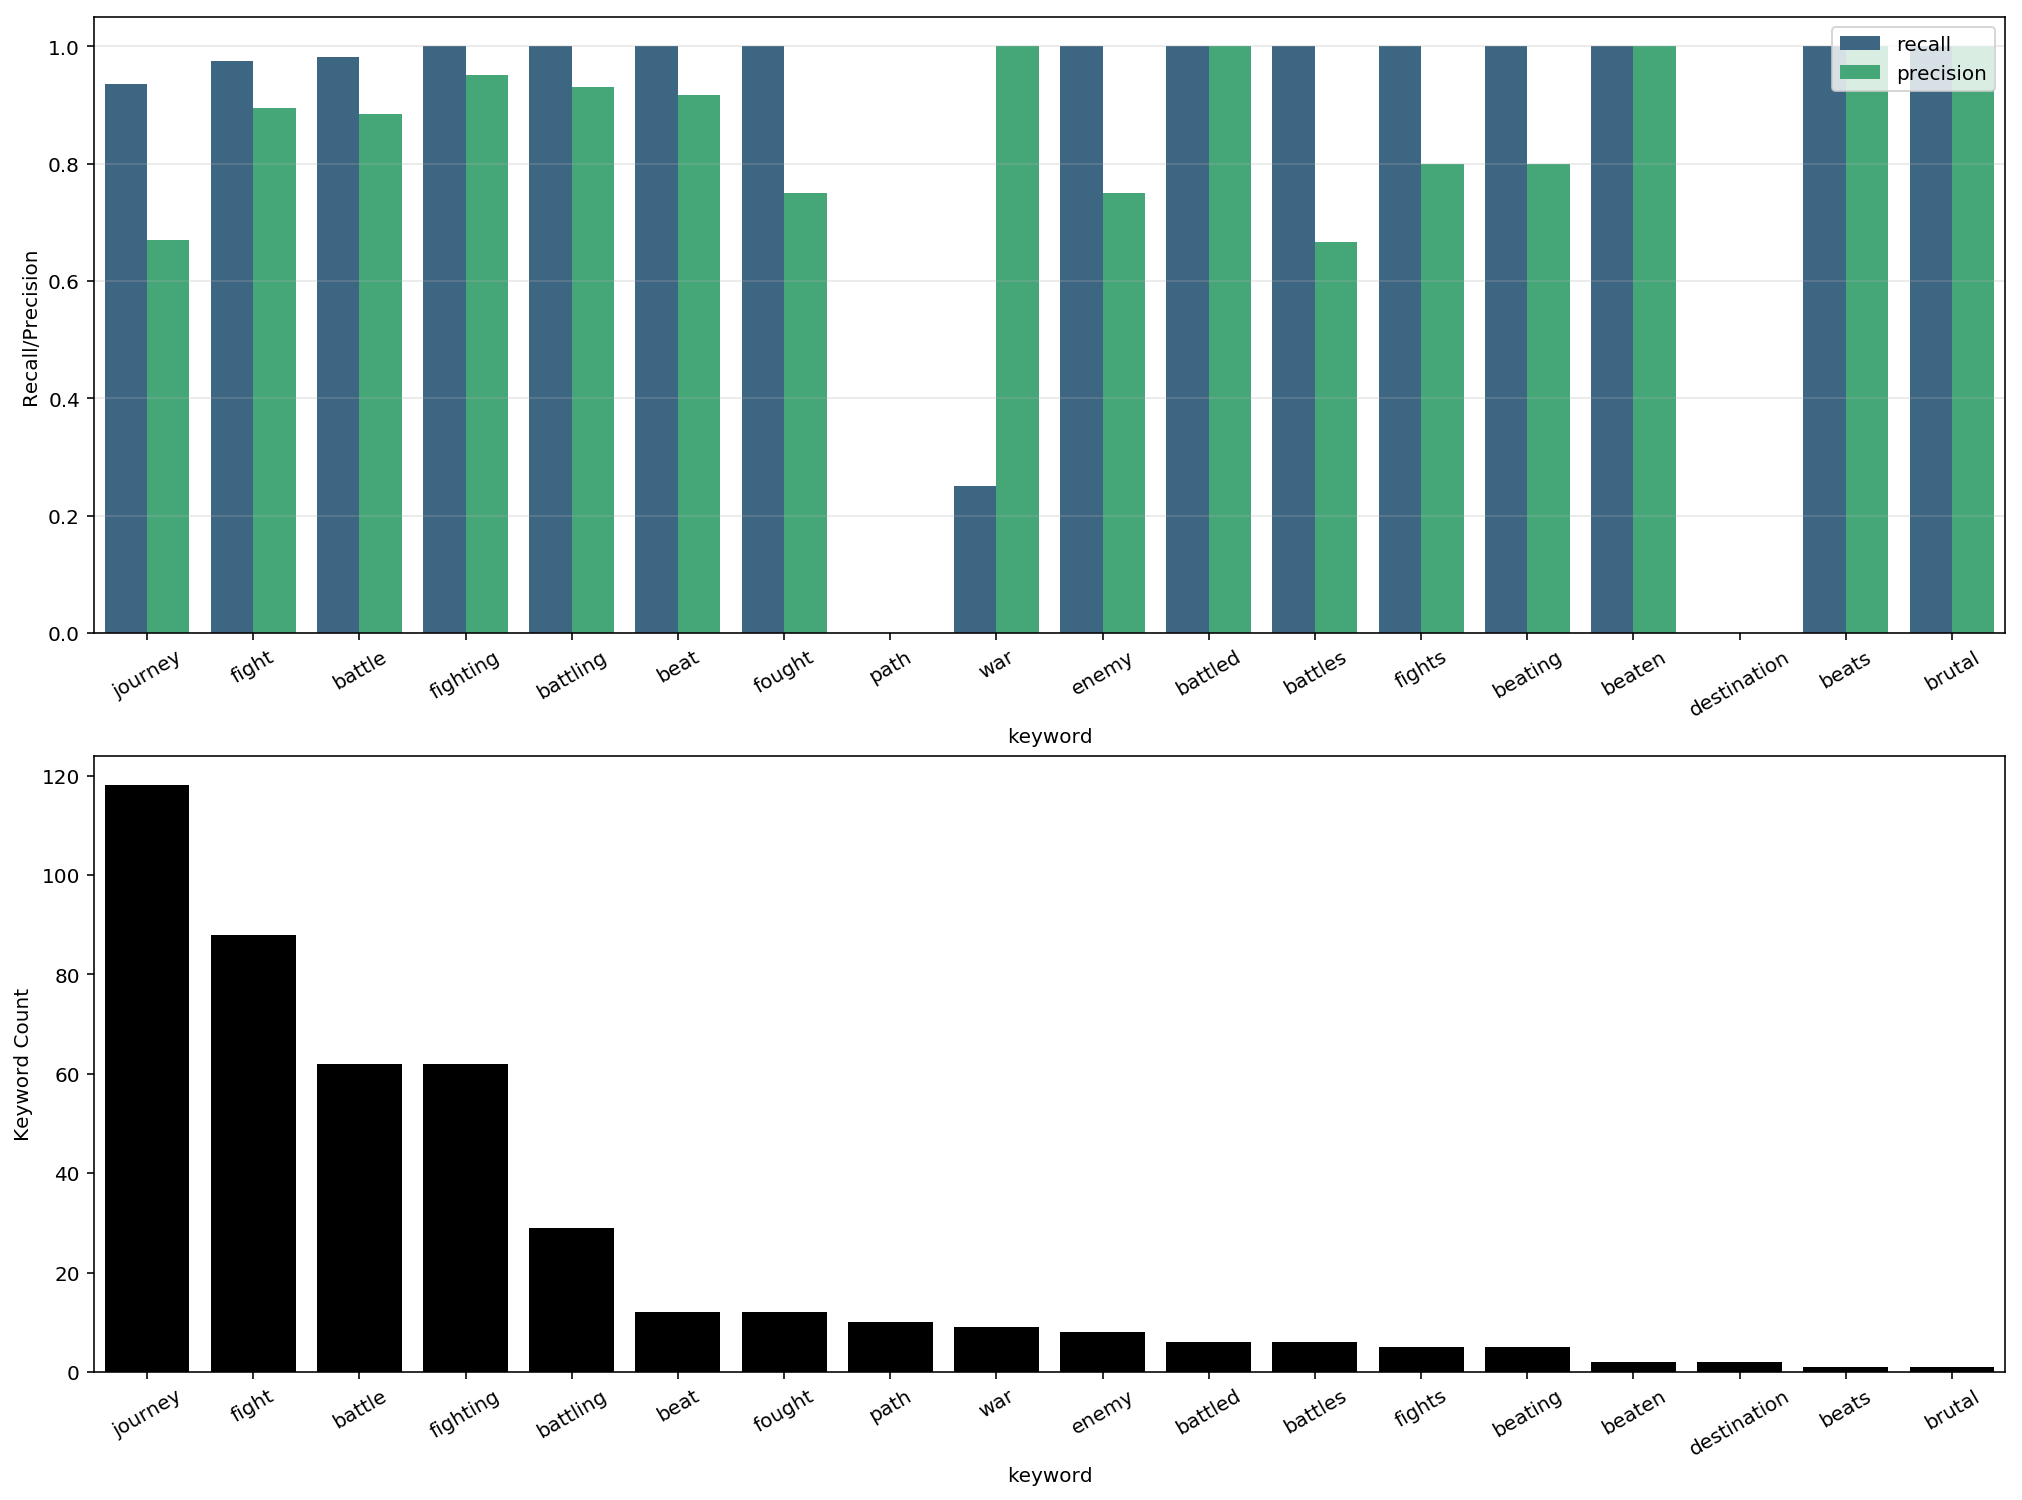

In [19]:
plt.subplots(figsize=(14,10))
plt.tight_layout()

plt.subplot(211)

g = sns.barplot(x='keyword', y='score', data=scores, hue='metric', palette='viridis')
plt.grid(alpha=0.3, axis='y')
plt.legend(loc='upper right')
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.set_ylabel('Recall/Precision');

plt.subplot(212)

g = sns.barplot(x='keyword', y='c', data=scores, color='k')
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.set_ylabel('Keyword Count');

0.8538285610578743


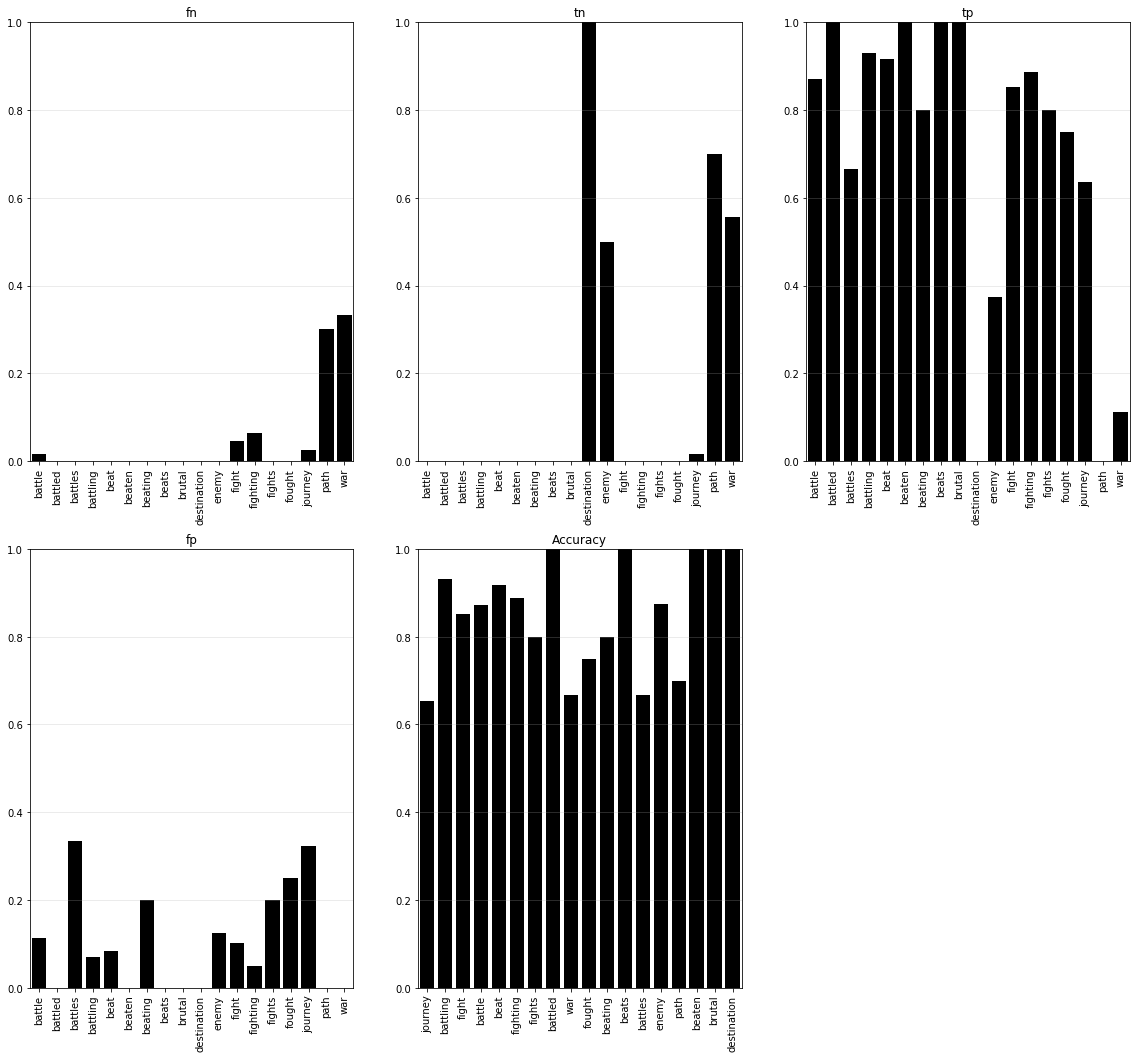

In [66]:
plt.subplots(figsize=(16,14))
plt.tight_layout()
tp = pd.Series(counts['tp'])
tn = pd.Series(counts['tn'])
fp = pd.Series(counts['fp'])
fn = pd.Series(counts['fn'])
# mcc = ((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
# print(mcc.mean())
acc = (tp + tn) / (tp + tn + fp + fn)
print(acc.mean())

for i, k in enumerate(counts):
    plt.subplot(2, 3, i+1)
    v = pd.Series(counts[k]) / pd.Series(totals)
    g = sns.barplot(y = v.values, x = v.index, color='k')
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.ylim([0,1])
    plt.grid(alpha=0.3, axis='y')
    plt.title(k)
    
plt.subplot(235)
g = sns.barplot(y = acc.values, x = acc.index, color='k')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.ylim([0,1])
plt.grid(alpha=0.3, axis='y')
plt.title('Accuracy');

In [ ]:
for each true metaphor and non-metaphor show the performance of those keywords